## 문장 데이터 예시

In [1]:
sentence = ' 나는 밥을 먹었다 '

source_sentence = '<start>' + sentence
target_sentence = sentence + '<end>'

print('Source 문장 : ',source_sentence)
print('Target 문장 : ',target_sentence)

## 문장 생성
### 데이터 다듬기

In [2]:
import re                  # 정규표현식을 위한 Regex 지원 모듈 (문장 데이터를 정돈하기 위해) 
import numpy as np         # 변환된 문장 데이터(행렬)을 편하게 처리하기 위해
import tensorflow as tf    # 대망의 텐서플로우!
import os

# 파일 읽기모드로 열기
file_path = '/home/aiffel0049/aiffel/Exploration/11.make_sentence/data/shakespeare.txt'
with open(file_path, 'r') as f:
    raw_corpus = f.read().splitlines()  # 텍스트를 라인 단위로 끊어서 list로 부르기

print(raw_corpus[:9])

['First Citizen:', 'Before we proceed any further, hear me speak.', '', 'All:', 'Speak, speak.', '', 'First Citizen:', 'You are all resolved rather to die than to famish?', '']


- 화자(':'로 끝나는 문장), 길이=0인 문장은 제거

In [3]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0:   # 길이가 0인 문장은 건너뜁니다.
        continue
    if sentence[-1] == ':':  # 문장의 끝이 : 인 문장은 건너뜁니다.
        continue
    
    if idx > 9:
        break  # 9개 문장만 확인

    print(sentence)

Before we proceed any further, hear me speak.
Speak, speak.
You are all resolved rather to die than to famish?


#### 토큰화(tokenize)
- 문장부호 (',', '.')
- 대소문자 (First, first 등 대소문자에 따른 다른 의미)
- 특수문자 (ten-year-old : 한 단어로 인식)

In [17]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()  # 소문자 전환, 띄어쓰기 제거
    
    sentence = re.sub(r'([?.!,¿])', r' \1 ', sentence)  # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', ' ', sentence)   # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r'[^a-zA-Z?.!,¿]+', " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환
    
    sentence = sentence.strip()
    
    sentence = '<start> ' + sentence + ' <end>'  # 이전 스텝에서 본 것처럼 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
    
    return sentence

print(preprocess_sentence('This @_is ;;;sample        sentence.'))

<start> this is sample sentence . <end>


#### source, target 문장

In [18]:
corpus = []
for sentence in raw_corpus:
    if len(sentence) == 0:
        continue
    if sentence[-1] == ':':
        continue
    
    corpus.append(preprocess_sentence(sentence))

corpus[:10]

['<start> before we proceed any further , hear me speak . <end>',
 '<start> speak , speak . <end>',
 '<start> you are all resolved rather to die than to famish ? <end>',
 '<start> resolved . resolved . <end>',
 '<start> first , you know caius marcius is chief enemy to the people . <end>',
 '<start> we know t , we know t . <end>',
 '<start> let us kill him , and we ll have corn at our own price . <end>',
 '<start> is t a verdict ? <end>',
 '<start> no more talking on t let it be done away , away ! <end>',
 '<start> one word , good citizens . <end>']

##### 문자를 벡터로 바꿔줌
- vertorize

In [19]:
def tokenize(corpus):
    # Tokenizer 패키지 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000,  # 전체 단어의 개수
        filters=' ',  # 별도로 전처리 로직을 추가할 수 있음
        oov_token='<unk>'  # out-of-vocabulary, 사전에 없는 단어 처리
    )
    tokenizer.fit_on_texts(corpus)  # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축
    
    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋 구축
    tensor = tokenizer.texts_to_sequences(corpus)  # tokenizer는 구축한 사전으로부터 corpus를 해석해 tensor로 변환
    
    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위해 padding 메소드 제공됨
    # maxlen의 디폴트값 = None, 지금의 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰짐
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2  143   40 ...    0    0    0]
 [   2  110    4 ...    0    0    0]
 [   2   11   50 ...    0    0    0]
 ...
 [   2  149 4553 ...    0    0    0]
 [   2   34   71 ...    0    0    0]
 [   2  945   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f742627d290>


In [20]:
print(tensor[:3, :10])

[[   2  143   40  933  140  591    4  124   24  110]
 [   2  110    4  110    5    3    0    0    0    0]
 [   2   11   50   43 1201  316    9  201   74    9]]


##### 단어 사전

In [21]:
for idx in tokenizer.index_word:
    print(idx, " : ", tokenizer.index_word[idx])
    
    if idx >= 10:
        break

1  :  <unk>
2  :  <start>
3  :  <end>
4  :  ,
5  :  .
6  :  the
7  :  and
8  :  i
9  :  to
10  :  of


In [33]:
src_input = tensor[:, :-1]  # 마지막을 제외한 문장 토큰을 source, 마지막 토큰은 <END> 보다는 <pad>능성이 높습니다.
tgt_input = tensor[:, 1:]  # tensor에서 <START>를 잘라내 타겟 문장 생성

print(src_input.shape)
print(src_input[0])
print(tgt_input[0])

(24015, 20)
[  2 143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0
   0   0]
[143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0   0
   0   0]


In [24]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1  # tokenizer에 있는 7천개 + 1: <pad>까지 7001개

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 20), (256, 20)), types: (tf.int32, tf.int32)>

### 인공지능 모델 학습

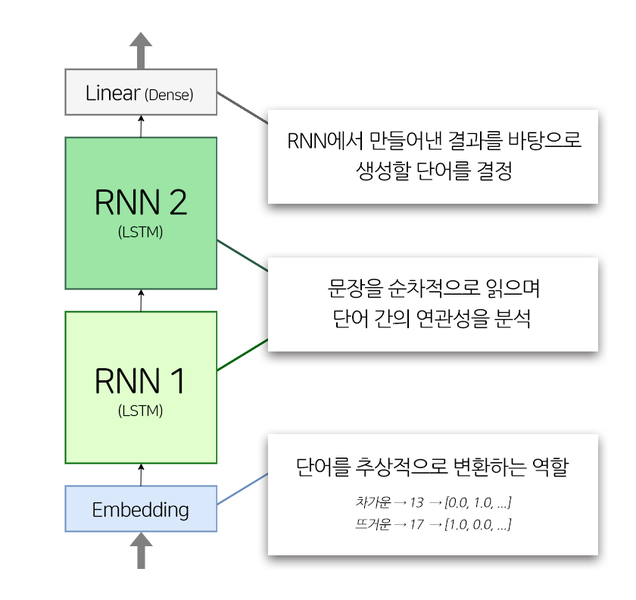

In [29]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
    
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)

- input tensor : 단어 사전의 인덱스 들어있음
- embedding layer : 인덱스 값 -> 해당 인덱스 번째의 워드 벡터로 변경
- 워드벡터 : 의미 벡터 공간에서 단어의 추상적 표현(representation)으로 사용됨
    - 차갑다: [0.0, 1.0]
    - 뜨겁다: [1.0, 0.0]
    - 미지근하다: [0.5, 0.5]   
        -> 데이터가 충분치 않으면, 학습이 잘 안됨




- LSTM의 hidden_size : 모델내에서 데이터로부터 특성을 추출하는 개수
- return_sequences
    - True : 입력된 Sequence길이만큼 동일한 시퀀스 출력
    - False : 1개의 벡터만 출력함

In [30]:
for src_sample, tgt_sample in dataset.take(1):
    break
model(src_sample)

<tf.Tensor: shape=(256, 20, 7001), dtype=float32, numpy=
array([[[ 8.8707151e-05,  6.6256973e-05, -7.2956187e-05, ...,
         -1.7346279e-04,  1.1405017e-04, -7.4191696e-05],
        [-9.2536888e-05,  4.5700130e-04, -2.9564026e-04, ...,
         -2.6519794e-04,  2.7288834e-04, -4.2956715e-04],
        [-2.1004886e-04,  9.0725400e-04, -5.0104689e-04, ...,
         -4.3996199e-04,  3.4590944e-04, -6.5795664e-04],
        ...,
        [-1.6460156e-03,  4.4615194e-04,  5.0121354e-04, ...,
          1.0973685e-03,  3.0473240e-03,  2.7792084e-03],
        [-1.7137632e-03,  8.1542775e-04,  4.9683126e-04, ...,
          1.1209032e-03,  3.3810947e-03,  3.2518683e-03],
        [-1.7577948e-03,  1.1804379e-03,  4.9412920e-04, ...,
          1.1588880e-03,  3.6196029e-03,  3.6767200e-03]],

       [[ 8.8707151e-05,  6.6256973e-05, -7.2956187e-05, ...,
         -1.7346279e-04,  1.1405017e-04, -7.4191696e-05],
        [ 2.2397729e-05, -5.4028433e-06, -1.6754121e-04, ...,
         -4.9368857e-04, -

In [34]:
model.summary()

Model: "text_generator_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  1792256   
_________________________________________________________________
lstm_4 (LSTM)                multiple                  5246976   
_________________________________________________________________
lstm_5 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense_2 (Dense)              multiple                  7176025   
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


- output shape : 입력하기 전엔 sequence 길이를 알 수가 없음   
    -> maxlen = 20이므로, sequence = 20으로 고정됨

In [35]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [36]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction = 'none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=30)

Epoch 1/30
93/93 [==============================] - 16s 170ms/step - loss: 3.5268
Epoch 2/30
93/93 [==============================] - 16s 172ms/step - loss: 2.8170
Epoch 3/30
93/93 [==============================] - 16s 172ms/step - loss: 2.7370
Epoch 4/30
93/93 [==============================] - 16s 173ms/step - loss: 2.6470
Epoch 5/30
93/93 [==============================] - 16s 171ms/step - loss: 2.5773
Epoch 6/30
93/93 [==============================] - 16s 172ms/step - loss: 2.5282
Epoch 7/30
93/93 [==============================] - 16s 172ms/step - loss: 2.4809
Epoch 8/30
93/93 [==============================] - 16s 174ms/step - loss: 2.4298
Epoch 9/30
93/93 [==============================] - 16s 172ms/step - loss: 2.3849
Epoch 10/30
93/93 [==============================] - 16s 174ms/step - loss: 2.3426
Epoch 11/30
93/93 [==============================] - 16s 173ms/step - loss: 2.3055
Epoch 12/30
93/93 [==============================] - 16s 173ms/step - loss: 2.2654
Epoch 13/30
9

### 모델로 작문시키기

In [37]:
def generate_text(model, tokenizer, init_sentence='<start>', max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index['<end>']
    
    # 텍스트를 실제로 생성할 때, 루프를 돌면서 단어 하나씩 생성해야 함
    while True:
        predict = model(test_tensor)
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]  # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됨
        
        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여줌
        test_tensor = tf.concat([test_tensor, 
                                tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 우리 모델이 <END>를 예측 or max_len에 도달하지 않았다면, while 루프를 돌며 다음 단어 예측해야 함
        if predict_word.numpy()[0] == end_token:
            break
        if test_tensor.shape[1] >= max_len:
            break
    
    generated = ''
    # 생성된 tensor안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + ' '
    
    return generated  # 이것이 최종적으로 모델이 생성한 자연어 문장

In [39]:
generate_text(model, tokenizer, init_sentence="<start> he")

'<start> he s a changeling and of the <unk> of the <end> '

In [40]:
generate_text(model, tokenizer, init_sentence="<start> she")

'<start> she s not fourteen . <end> '